In [1]:
import matplotlib.pyplot as plt

import numpy as np
import torch
import os
from ctd.comparison.analysis.tt.tasks.tt_MultiTask import Analysis_TT_MultiTask 
# Import pca
from sklearn.decomposition import PCA
import glob
import cv2
import shutil
import imageio

In [2]:

suffix = "MultiTaskNoisyGRU"
filepath1 = (
"/home/csverst/Github/CtDBenchmark/content/trained_models/task-trained/20241007_MultiTask_NoisyGRU_Final/max_epochs=150_latent_size=64_weight_decay=1.00E-05_seed=0/"
)
plot_path = (
    f"/home/csverst/Github/CtDBenchmark/examples/{suffix}/"
)
os.makedirs(plot_path, exist_ok=True)


phase_plot = "mem1"
phase_for_pca = "mem1"
task_to_analyze = "MemoryPro"
task_for_pca = "MemoryAnti"
plot_fps = True
do_interp = False
comp = Analysis_TT_MultiTask(run_name=suffix, filepath=filepath1)
    
# Get the model outputs
ics, inputs, targets = comp.get_model_inputs_noiseless()
out_dict = comp.get_model_outputs_noiseless()
lats = out_dict["latents"]
outputs = out_dict["controlled"]

# Get the flag for the task (which trials are the correct task)
pca_flag, pca_phase_task = comp.get_task_flag(task_for_pca)
lats4pca = lats[pca_flag].detach().numpy()

# Get the latent activity for the phase we want to do PCA on
lats_phase_pca = comp.get_data_from_phase(pca_phase_task, phase_for_pca, lats4pca)
lats_phase_pca_flat = np.concatenate(lats_phase_pca) 

# Compute PCA on the latents in the phase
pca = PCA(n_components=3)
pca.fit(lats_phase_pca_flat)

plot_flag, phase_task = comp.get_task_flag(task_to_analyze)

phase_names = phase_task[0].keys()
phase_names_pca = pca_phase_task[0].keys()
num_phases_pca = len(phase_names_pca)
num_phases = len(phase_names)

# Get the latents and outputs for the task

lats4plot = lats[plot_flag].detach().numpy()
outputs4plot = outputs[plot_flag].detach().numpy()
targets4plot = targets[plot_flag].detach().numpy()
trial_lens = [phase['response'][1] for phase in phase_task]
targ_list = np.array([targets4plot[i, trial_lens[i]-1,1:] for i in range(len(trial_lens))])
targ_ang_list = np.arctan2(targ_list[:,1], targ_list[:,0])
B, T, D = lats4plot.shape
# Get the readout matrix
readout = comp.wrapper.model.readout

lats_pca = pca.transform(lats4plot.reshape(-1, D))
lats_pca = lats_pca.reshape(B, T, -1)

# Get the full trial latents in the phase PCA space

In [3]:
if do_interp:
    n_interp_steps = 20
    fps = comp.plot_fps_phase_interpolation(
        task= task_to_analyze, 
        phase1= 'mem1', phase2= 'response', 
        n_interp_steps=n_interp_steps, max_iters_init = 2000, max_iters = 5000,
        lr = 5e-2, use_noisy= False)
    xstars = np.array([fp.xstar for fp in fps])

In [4]:
if do_interp:
    q_thresh = 1e-5
    q_flag = np.array([fp.qstar < q_thresh for fp in fps])
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')
    colors = plt.cm.jet(np.linspace(0,1,n_interp_steps))
    for i in range(n_interp_steps):
        xstar = xstars[i,:,:]
        xstar_pca = pca.transform(xstar)
        xstar_readout = readout(torch.Tensor(xstar)).detach().numpy()
        ax.scatter(
            xstar_pca[:,0], 
            xstar_pca[:,1], 
            xstar_readout[:,1], 
            color = colors[i], 
            label = f"Interp {i}"
            )
        
        # puase for 1 second
        # plt.pause(1)
    # set view to see the plot from above
    ax.view_init(90, 0)
    # set view to see the plot from the front
    ax.view_init(0, 85)
    # ax.legend()

    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('Output')
    ax.set_xlim([-3, 3])
    ax.set_ylim([-3, 3])
    ax.set_zlim([-1.2, 1.2])
    ax.set_title('Fixed Points Interpolated') 
    # plt.savefig(plot_path + "FixedPointsPhaseInterp.pdf")
    plt.show()

In [5]:
if do_interp:
    fps_task = comp.compute_fps_task_interpolation(
    task1 = "MemoryPro",
    task2 = "MemoryAnti",
    phase = 'mem1',
    n_interp_steps=n_interp_steps, 
    max_iters_init = 10000, max_iters = 2000,
    lr = 1e-3, use_noisy= False)
    
    xstars_task = np.array([fp.xstar for fp in fps_task])

In [6]:
if do_interp:
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')
    colors = plt.cm.jet(np.linspace(0,1,n_interp_steps))
    for i in range(n_interp_steps):
        xstar = xstars_task[i,:,:]
        xstar_pca = pca.transform(xstar)
        xstar_readout = readout(torch.Tensor(xstar)).detach().numpy()
        ax.scatter(
            i, 
            xstar_pca[:,0], 
            xstar_pca[:,1], 
            color = colors[i]
            )

    ax.set_xlabel('Interpolation Step')
    ax.set_ylabel('PC1')
    ax.set_zlabel('PC2')

    # set view to see the plot from the front
    # ax.view_init(0, 90)
    ax.set_title('Task-Interpolated FPs (MemoryPro to MemoryAnti)') 

    plt.savefig(plot_path + "FixedPointsTaskInterp.png")
    plt.savefig(plot_path + "FixedPointsTaskInterp.pdf")
    plt.show()

Computing fixed points for context using ['context', 'mem1']

Iteration 500/2000
q = 1.44E-03 +/- 3.28E-03
dq = 3.83E-06 +/- 1.04E-05

Iteration 1000/2000
q = 5.49E-04 +/- 1.05E-03
dq = 7.74E-07 +/- 1.79E-06

Iteration 1500/2000
q = 3.12E-04 +/- 5.48E-04
dq = 2.95E-07 +/- 5.85E-07

Iteration 2000/2000
q = 2.03E-04 +/- 3.49E-04
dq = 1.61E-07 +/- 2.88E-07
Maximum iteration count reached. Terminating.
Found 2048 unique fixed points.
Computing fixed points for stim1 using stim1

Iteration 500/2000
q = 1.61E-03 +/- 3.40E-03
dq = 4.13E-06 +/- 9.52E-06

Iteration 1000/2000
q = 6.21E-04 +/- 1.23E-03
dq = 9.12E-07 +/- 1.93E-06

Iteration 1500/2000
q = 3.36E-04 +/- 6.55E-04
dq = 3.49E-07 +/- 7.13E-07

Iteration 2000/2000
q = 2.12E-04 +/- 4.10E-04
dq = 1.76E-07 +/- 3.57E-07
Maximum iteration count reached. Terminating.
Found 2048 unique fixed points.
Computing fixed points for mem1 using ['mem1']

Iteration 500/2000
q = 3.94E-04 +/- 1.81E-03
dq = 1.18E-06 +/- 5.99E-06

Iteration 1000/2000
q = 1.3

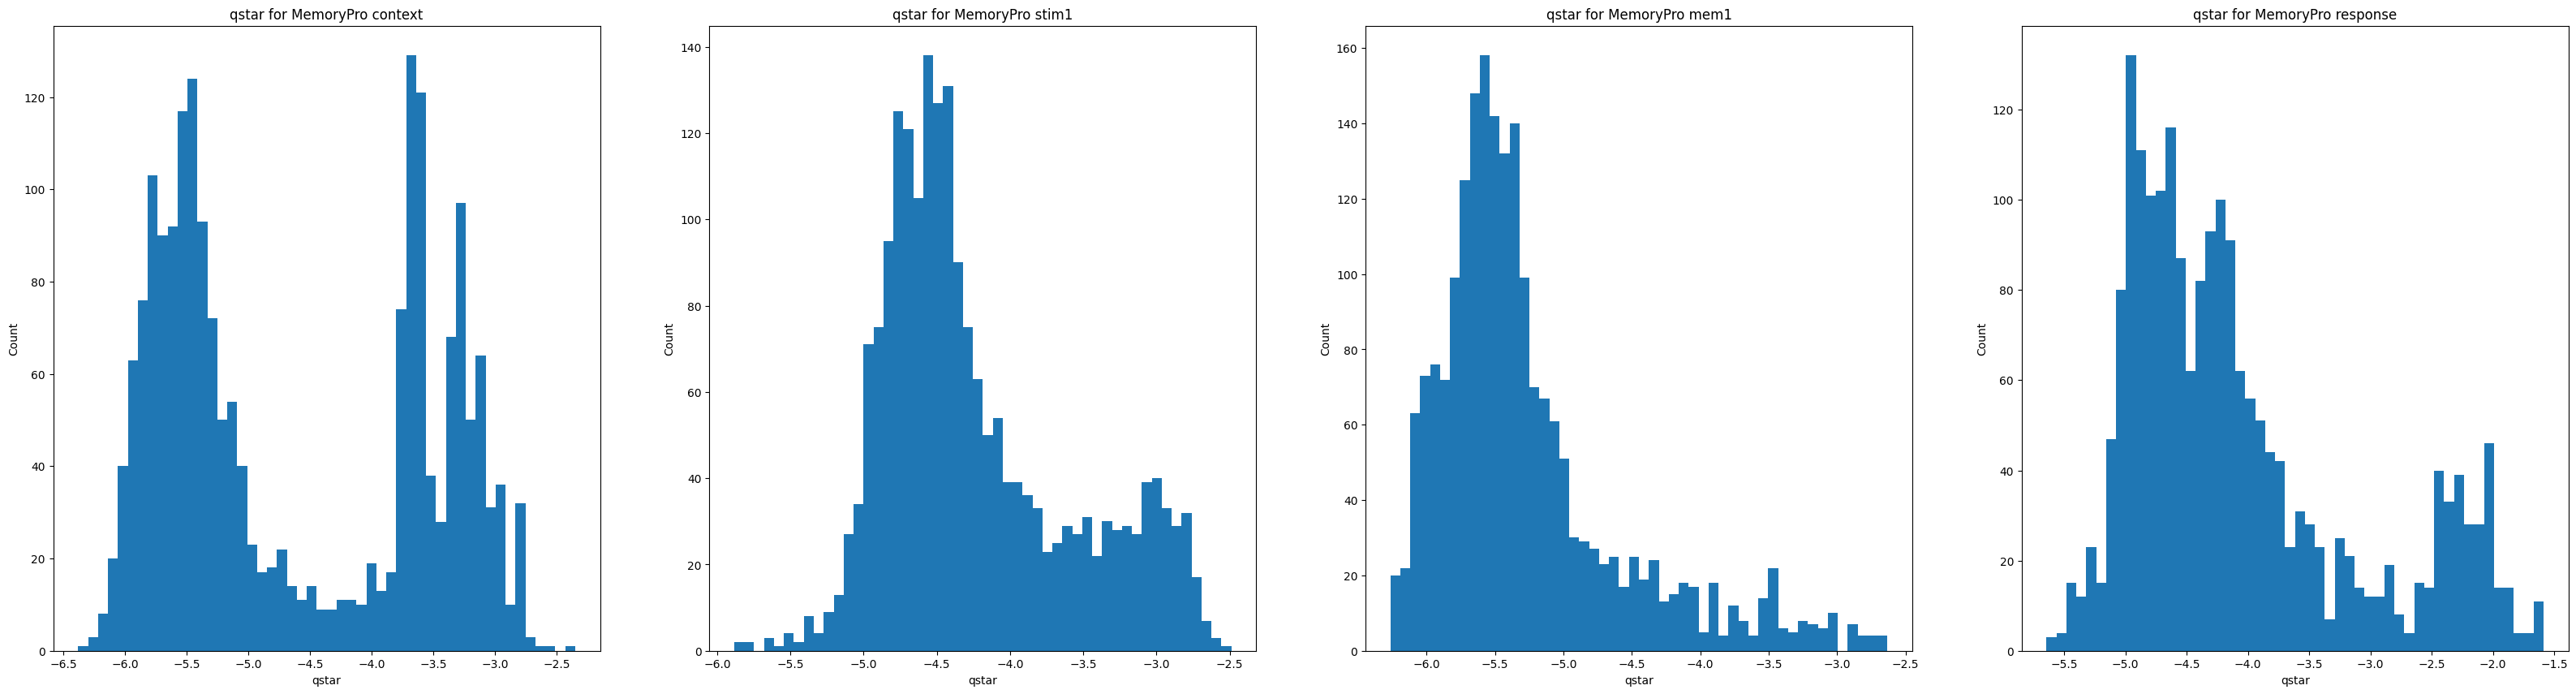

In [7]:
fps = {}
xstar_pca = []
fps_out = []
q_star = []
phase_names = ['context', 'stim1', 'mem1', 'response']
phase_list = [['context', 'mem1'], 'stim1', ['mem1'], 'response']
# For each phase, compute the fixed points
for i, phase_for_fp in enumerate(phase_list):
    print(f"Computing fixed points for {phase_names[i]} using {phase_for_fp}")
    # Returns fps and x_trajs in the original space
    fps[phase_names[i]]= comp.compute_fps_phase(
        phases=phase_for_fp, 
        task_to_analyze=task_to_analyze, 
        noise_scale=0.0, lr = 1e-3, 
        max_iters = 2000, use_noisy = False
        )

    # Transform the fps and x_trajs into the PCA space
    xstar= fps[phase_names[i]].xstar
    xstar_pca.append(pca.transform(xstar))
    fps_out.append(readout(torch.Tensor(xstar)).detach().numpy())
    q_star.append(fps[phase_names[i]].qstar)
xstar_pca = np.stack(xstar_pca, axis = 0)
fps_out = np.stack(fps_out, axis = 0)
fps_mat = np.concatenate((xstar_pca[:,:,:2], fps_out[:,:,1:2]), axis=2)
q_star = np.stack(q_star, axis = 0)
# Set values of qstar that are zero to 1e-16 for plotting
q_star[q_star == 0] = 1e-16
fig = plt.figure(figsize=(10*num_phases, 10))
for i, phase in enumerate(phase_names):
    # Add histogram of qstar
    ax = fig.add_subplot(1, num_phases, i+1)
    ax.hist(np.log10(q_star[i]), bins=50)
    ax.set_xlabel("qstar")
    ax.set_ylabel("Count")
    ax.set_title(f"qstar for {task_to_analyze} {phase}")
# plt.savefig(comp.plot_path + f"qstar_{task_to_analyze}_{phase}.png", dpi=300)
plt.show()


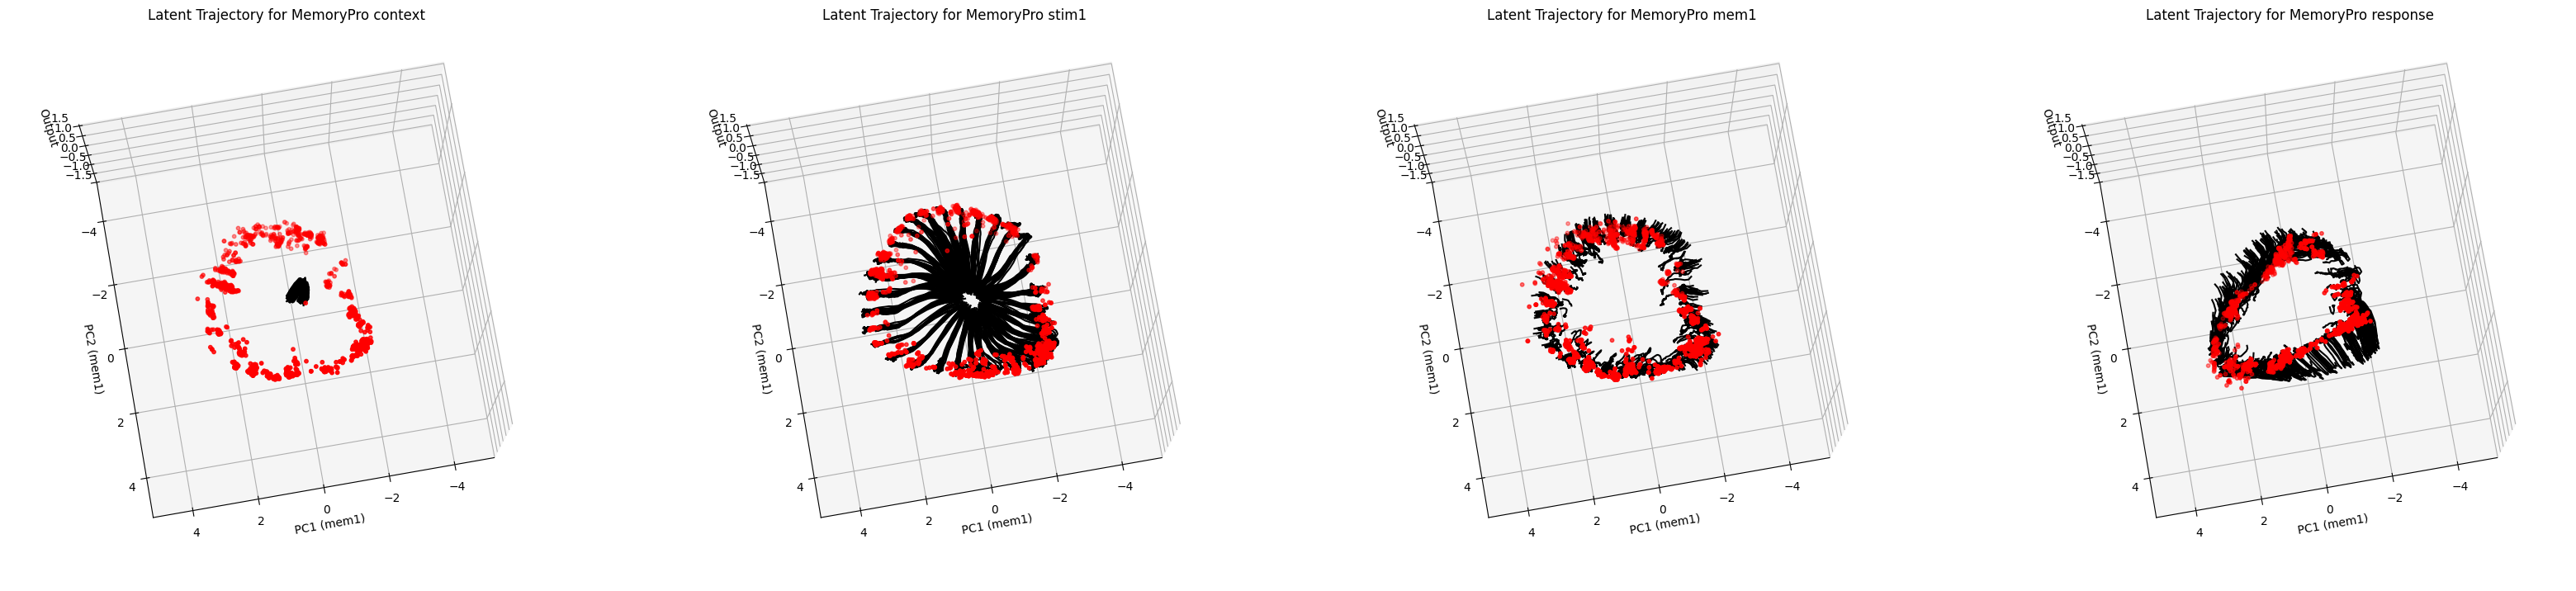

In [8]:
# window to only FPs whose q values are less than thresh
fps_plot = fps_mat.copy()
threshs = [1e-4,5e-4, 5e-4, 1e-4]
for i, phase in enumerate(phase_names):
    q_flag = q_star[i] < threshs[i]
    fps_plot[i, ~q_flag, :] = np.nan
# combine lats_pca 1 and 2 and output 1
plot_mat = np.concatenate((lats_pca[:, :, :2], outputs4plot[:, :, 1:2]), axis=2)
fig = plt.figure(figsize=(10*num_phases, 10))
for i, phase in enumerate(phase_names):
    ax = fig.add_subplot(1, num_phases, i+1, projection="3d")
    for j, phase_dict in enumerate(phase_task):
        start_idx = phase_dict[phase][0]
        end_idx = phase_dict[phase][1]
        ax.plot(
            plot_mat[j,start_idx:end_idx, 0], 
            plot_mat[j,start_idx:end_idx, 1], 
            plot_mat[j,start_idx:end_idx, 2], 
            c="k"
            )
    ax.scatter(
        fps_plot[i,:,0], 
        fps_plot[i,:,1], 
        fps_plot[i,:,2], 
        s=10, c="r"
        )
    ax.set_xlabel(f"PC1 ({phase_for_pca})")
    ax.set_ylabel(f"PC2 ({phase_for_pca})")
    ax.set_zlabel("Output")
    ax.set_title(f"Latent Trajectory for {task_to_analyze} {phase}")
    ax.set_xlim([-5, 5])
    ax.set_ylim([-5, 5])
    ax.set_zlim([-1.5, 1.5])
    
    ax.view_init(80, 80)
    # if phase == 'response':
    #     ax.view_init(0, 0)
plt.show()
# plt.savefig(comp.plot_path + f"LatentTraj_{task_to_analyze}_{phase}.png", dpi=300)

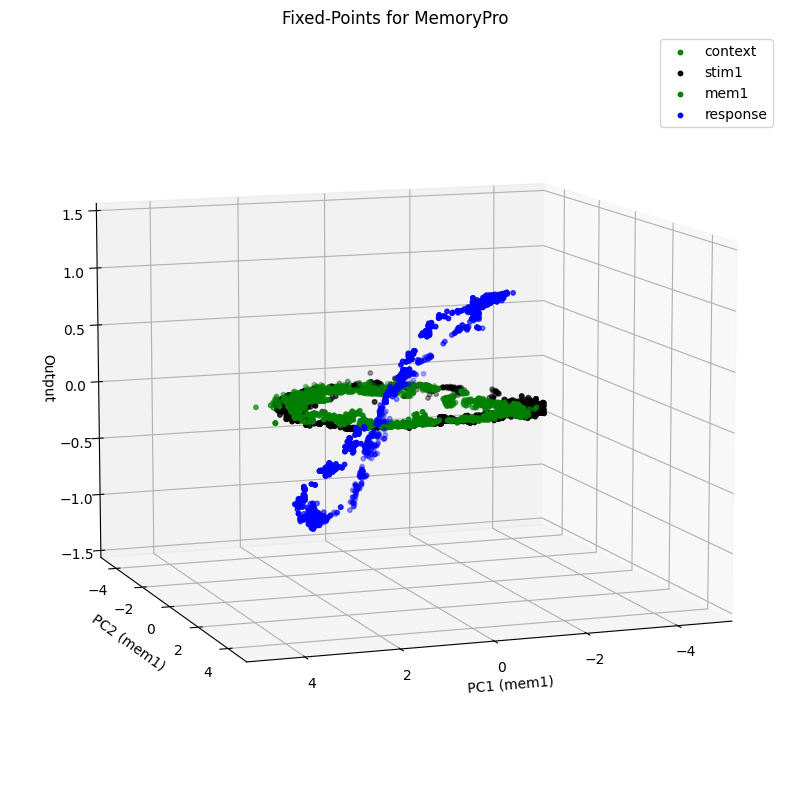

In [9]:
fps_plot = fps_mat.copy()
color_mat = ['g', 'k', 'g', 'b']
phase_nums = [0,1,2,3]
for i, phase in enumerate(phase_names):
    q_flag = q_star[i] < threshs[i]
    fps_plot[i, ~q_flag, :] = np.nan
# combine lats_pca 1 and 2 and output 1
plot_mat = np.concatenate((lats_pca[:, :, :2], outputs4plot[:, :, 1:2]), axis=2)
fig = plt.figure(figsize=(10, 10))

ax = fig.add_subplot(1, 1, 1, projection="3d")
for i in phase_nums:
    ax.scatter(
        fps_plot[i,:,0], 
        fps_plot[i,:,1], 
        fps_plot[i,:,2], 
        s=10, c=color_mat[i],
        label = phase_names[i]
        )
    ax.set_xlabel(f"PC1 ({phase_for_pca})")
    ax.set_ylabel(f"PC2 ({phase_for_pca})")
    ax.set_zlabel("Output")
    ax.set_title(f"Fixed-Points for {task_to_analyze}")
    ax.set_xlim([-5, 5])
    ax.set_ylim([-5, 5])
    ax.set_zlim([-1.5, 1.5])
    ax.legend()
    
    # ax.view_init(80, 80)
    if phase == 'response':
        ax.view_init(10, 70)
# plt.show()
plt.savefig(f"FixedPoints_{task_to_analyze}.pdf", dpi=300)

In [10]:

def angles_to_colors(angles):
    # Normalize the angles to the range [0, 1]
    normalized = (angles + np.pi) / (2 * np.pi)
    
    # Use a circular (hsv) colormap
    colormap = plt.cm.hsv
    
    # Map normalized angles to colors
    colors = colormap(normalized)
    return colors

def create_frames(
        plot_mat,
        fps_mat, 
        q_star, 
        threshs,
        trail_length = 5, 
        target_ang_list = None, 
        num_frames_per_phase=60
        ):
    frame_folder = "combined_frames"
    os.makedirs(frame_folder, exist_ok=True)
    frame_count = 0
    
    # Make a colormap for the phases
    if target_ang_list is None:
        colors = plt.cm.get_cmap('gist_rainbow', len(phase_names))
    else:
        colors = angles_to_colors(target_ang_list)

    colors_label = plt.cm.get_cmap('gist_rainbow', len(phase_names))
    
    # Make a colormap for the phases
    for i, phase in enumerate(phase_names):
        print(f"\rCreating frames for {phase}", end="")
        for frame in range(num_frames_per_phase):
            print(f"Frame {frame_count+1} of {num_frames_per_phase * len(phase_names)}")
            fig = plt.figure(figsize=(10, 10))
            ax = fig.add_subplot(111, projection="3d")

            # Plotting logic (adapted for trail effect)
            # Plot the trajectory up to the current frame
            q_flag = q_star[i] < threshs[i]
            fps_phase = fps_mat[i, q_flag, :]
            ax.scatter(fps_phase[:, 0], 
                       fps_phase[:, 1], 
                       fps_phase[:, 2], 
                       s=10, c="k")

            for j, phase_dict in enumerate(phase_task):
                start_idx = phase_dict[phase][0]
                end_idx = min(
                    phase_dict[phase][1], 
                    start_idx + int((phase_dict[phase][1] - start_idx) * frame / num_frames_per_phase)
                    )
                idx1 = max(0, end_idx - trail_length)

                if target_ang_list is None:
                    ax.plot(plot_mat[j, idx1:end_idx, 0], 
                            plot_mat[j, idx1:end_idx, 1], 
                            plot_mat[j, idx1:end_idx, 2], 
                            c=colors(i))
                else:
                    ax.plot(plot_mat[j, idx1:end_idx, 0], 
                            plot_mat[j, idx1:end_idx, 1], 
                            plot_mat[j, idx1:end_idx, 2], 
                            c=colors[j])
            
            # Set labels, limits, and title
            ax.set_xlabel(f"PC1 ({phase_for_pca})")
            ax.set_ylabel(f"PC2 ({phase_for_pca})")
            ax.set_zlabel("Output")
            ax.set_title(f"{task_to_analyze}")
            ax.set_xlim([-3, 3])
            ax.set_ylim([-3, 3])
            ax.set_zlim([-1.5, 1.5])
            # Add a text-box with the phasename and color-coded

            for label_num, phase_name_plot in enumerate(phase_names):
                
                props = dict(
                    boxstyle='round', 
                    facecolor=colors_label(label_num), 
                    alpha=0.25
                    )
                props_bold = dict(
                    boxstyle='round', 
                    facecolor=colors_label(label_num), 
                    alpha=1.0
                    )
                if phase_name_plot == phase:
                    ax.text2D(
                        0.05, 0.95-0.05*label_num, phase_name_plot, 
                        transform=ax.transAxes, fontsize=14,
                        verticalalignment='top', bbox=props_bold, 
                        fontweight='bold'
                        )
                else:
                    ax.text2D(
                        0.05, 0.95-0.05*label_num, 
                        phase_name_plot, transform=ax.transAxes, 
                        fontsize=14,
                        verticalalignment='top', bbox=props
                        )


            # Change view angle for each frame
            ax.view_init(
                30,
                30 + (frame / num_frames_per_phase) * 60
                )

            plt.savefig(f"{frame_folder}/frame_{frame_count:04d}.png")
            plt.close(fig)
            frame_count += 1


def create_combined_video(fps=10):
    frame_folder = "combined_frames"
    img_array = []
    for filename in sorted(glob.glob(f'{frame_folder}/*.png')):
        img = cv2.imread(filename)
        height, width, layers = img.shape
        size = (width, height)
        img_array.append(img)

    video = cv2.VideoWriter(
        comp.plot_path +f'{task_to_analyze}_{task_for_pca}PCs_combined_video.avi',
         cv2.VideoWriter_fourcc(*'DIVX'), 
         fps, size)

    for img in img_array:
        video.write(img)

    video.release()

    # Delete all frame files
    for filename in glob.glob(f'{frame_folder}/*.png'):
        os.remove(filename)

    # Delete the frame folder
    shutil.rmtree(frame_folder)


def create_combined_gif(fps=20):
    frame_folder = "combined_frames"
    filenames = sorted(glob.glob(f'{frame_folder}/*.png'))

    images = []
    for filename in filenames:
        images.append(imageio.imread(filename))

    # Set the duration for each frame
    duration = 1 / fps

    # Save the frames as a gif
    imageio.mimsave(f'{task_to_analyze}_{task_for_pca}PCs_combined_video.gif', images, duration=duration)

    # Cleanup: Delete frames and folder
    for filename in filenames:
        os.remove(filename)
    os.rmdir(frame_folder)

  
create_frames(
    plot_mat,fps_mat, 
    q_star, 
    threshs,
    target_ang_list=targ_ang_list, 
    num_frames_per_phase=60
    )
create_combined_gif()

# create_combined_video()

/tmp/ipykernel_515584/1813443760.py:31: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors_label = plt.cm.get_cmap('gist_rainbow', len(phase_names))


Creating frames for contextFrame 1 of 240
Frame 2 of 240
Frame 3 of 240
Frame 4 of 240
Frame 5 of 240
Frame 6 of 240
Frame 7 of 240
Frame 8 of 240
Frame 9 of 240
Frame 10 of 240
Frame 11 of 240
Frame 12 of 240
Frame 13 of 240
Frame 14 of 240
Frame 15 of 240
Frame 16 of 240
Frame 17 of 240
Frame 18 of 240
Frame 19 of 240
Frame 20 of 240
Frame 21 of 240
Frame 22 of 240
Frame 23 of 240
Frame 24 of 240
Frame 25 of 240
Frame 26 of 240
Frame 27 of 240
Frame 28 of 240
Frame 29 of 240
Frame 30 of 240
Frame 31 of 240
Frame 32 of 240
Frame 33 of 240
Frame 34 of 240
Frame 35 of 240
Frame 36 of 240
Frame 37 of 240
Frame 38 of 240
Frame 39 of 240
Frame 40 of 240
Frame 41 of 240
Frame 42 of 240
Frame 43 of 240
Frame 44 of 240
Frame 45 of 240
Frame 46 of 240
Frame 47 of 240
Frame 48 of 240
Frame 49 of 240
Frame 50 of 240
Frame 51 of 240
Frame 52 of 240
Frame 53 of 240
Frame 54 of 240
Frame 55 of 240
Frame 56 of 240
Frame 57 of 240
Frame 58 of 240
Frame 59 of 240
Frame 60 of 240
Creating frames for st

/tmp/ipykernel_515584/1813443760.py:151: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(filename))
